Some libraries that might need to be downloaded

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# Data Import and Split

To start off: looking at data. Importing in the cifar 10 dataset (10 classes, ~60k images). I want to do a 80-10-10 train-test-val split to make sure that I have enough training data since this isn't particularly large but also want to make sure that the proportion of each class stays the same within each set.

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras.datasets import cifar10
from keras.utils import to_categorical   
from sklearn.model_selection import train_test_split

def load_cifar10():

    (X_train, y_train), (X_test_val, y_test_val) = cifar10.load_data() #automatically gives train (80), val (20)
    #split val in half to get our val (10), test(10)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=True, stratify=y_test_val)

    return X_train, y_train, X_val, y_val, X_test, y_test


2023-12-15 04:35:29.934684: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 04:35:32.571110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 04:35:32.571229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 04:35:33.240717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 04:35:34.654116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 04:35:34.665547: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

In [7]:
#validation of dataset sizes and labels

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))


# Model Initialization and Training

Now that we have the dataset, let's start training a model. However, I want to test out two architectures here: one simple CNN (fast training and turnaround) and one more complex CNN (known to have top accuracy). This will hopefully provide insights into if model architectures plays a factor in how resistant a model can be to unlearning (we'll also try some overfitted/overtrained models).

In [8]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization

num_classes = 10

def get_model(simple=True):

    model = Sequential()

    if simple: #smaller model just for initial testing
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(num_classes, activation='softmax'))
    else:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    return model


Training initial model:

In [92]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = get_model(simple=False)

model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#callback checkpoint to save weights every 10 epochs
model_checkpoint_callback = ModelCheckpoint(
    filepath="initial_trained_model/model_weights.{epoch:02d}-{val_accuracy:.2f}.h5",
    save_weights_only=True,
    save_freq='epoch',  # Save weights every epoch
    period=10  # Save weights every 10 epochs (optional, but you can keep it for compatibility)
)

#call early stop to stop training if loss stops improving after 3 epochs
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(
    X_train,
    to_categorical(y_train),
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val, to_categorical(y_val)),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
782/782 [==============================] - 227s 286ms/step - loss: 1.7941 - accuracy: 0.3881 - val_loss: 1.2702 - val_accuracy: 0.5476
Epoch 2/100
782/782 [==============================] - 224s 287ms/step - loss: 1.2036 - accuracy: 0.5714 - val_loss: 0.9819 - val_accuracy: 0.6550
Epoch 3/100
782/782 [==============================] - 223s 286ms/step - loss: 1.0111 - accuracy: 0.6434 - val_loss: 0.8950 - val_accuracy: 0.6802
Epoch 4/100
782/782 [==============================] - 223s 285ms/step - loss: 0.8880 - accuracy: 0.6903 - val_loss: 1.0737 - val_accuracy: 0.6448
Epoch 5/100
782/782 [==============================] - 223s 285ms/step - loss: 0.8234 - accuracy: 0.7133 - val_loss: 0.6912 - val_accuracy: 0.7604
Epoch 6/100
782/782 [==============================] - 222s 284ms/step - 

In [95]:
model.save_weights("initial_trained_model/model_weights.85-0.87.h5")

score = model.evaluate(X_test, to_categorical(y_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 6s 38ms/step - loss: 0.4440 - accuracy: 0.8654
Test loss: 0.4439763128757477
Test accuracy: 0.8654000163078308


# Model Reinitialization

Since this model did take a considerable amount of time to train and has a risk of overfitting, I saved weights every epochs, allowing for me to choose a model after "x0" epochs to use rather than after 100 epochs to evaluate different results

In [34]:
model = get_model(simple=False)

model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#model.load_weights("initial_trained_model/model_weights.85-0.87.h5")
model.load_weights("retain_set_retrained_model-unlearnbatch6/model_weights.100-0.86.h5")

# Retain set

In a perfect world, when we're encountered with situations where we need machine unlearning, we would remove the label from our dataset and then retrain the model from scratch. This guarantees us that there's no trace of this data in the model. However, in reality, this is expensive and unrealistic.

Now we want to split our train dataset into the retain and forget sets. Here are some functions that help us accomplish that

In [9]:
np.random.seed(42)

# this removes an entire class
def split_to_retain_and_forget(X, y, unlearn_class_label):
    retain_mask = (y != unlearn_class_label).squeeze(axis=1)
    
    X_retain = X[retain_mask]
    y_retain = y[retain_mask]
    
    forget_mask = (y == unlearn_class_label).squeeze(axis=1)
    
    X_forget = X[forget_mask]
    y_forget = y[forget_mask]

    return X_retain, y_retain, X_forget, y_forget

#Since the forget set only includes examples of one label, it doesn't get converted to a proper one hot encoding, so we need to force it.
def pad_array(original_array, desired_length):
    num_zeros_to_pad = max(0, desired_length - original_array.shape[1])
    padded_array = np.pad(original_array, ((0, 0), (0, num_zeros_to_pad)), mode='constant', constant_values=0)

    return padded_array

# this splits off a certain number of examples of a class
def split_to_retain_and_forget_examples(X, y, unlearn_class_label, num_example):
    retain_mask = (y != unlearn_class_label).squeeze(axis=1)
    forget_mask = (y == unlearn_class_label).squeeze(axis=1)

    forget_indices = np.where(forget_mask)[0]

    if num_example > len(forget_indices):
        raise ValueError("num_example cannot be larger than the number of available examples")
    else:
        forget_subset = np.random.choice(forget_indices, size=num_example, replace=False)

    X_forget = X[forget_subset]
    y_forget = y[forget_subset]

    retain_subset = np.setdiff1d(forget_indices, forget_subset)
    X_retain = np.concatenate((X[retain_mask], X[retain_subset]), axis=0)
    y_retain = np.concatenate((y[retain_mask], y[retain_subset]), axis=0)

    return X_retain, y_retain, X_forget, y_forget

# Unlearn specific examples

Unlearning an entire class can provide some insights but unlearning specific examples yields more compelling revelations, especially because in cifar-10, some of the classes are drastically different from one another. We also print out some the images for a better understanding.

In [10]:
unlearn_class = 6
X_train_retain, y_train_retain, X_train_forget, y_train_forget = split_to_retain_and_forget_examples(X_train, y_train, unlearn_class, num_example=30)

print(X_train_retain.shape)
print(y_train_retain.shape)
print(np.unique(y_train_retain, return_counts=True))

print(X_train_forget.shape)
print(y_train_forget.shape)
print(np.unique(y_train_forget, return_counts=True))

adjusted_y_train_forget = to_categorical(y_train_forget)
desired_length = 10
adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

(49970, 32, 32, 3)
(49970, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 4970, 5000, 5000, 5000]))
(30, 32, 32, 3)
(30, 1)
(array([6], dtype=uint8), array([30]))


Now that we have the split and our forget set, let's see how our initial fully trained model performs on it:

In [110]:
model.load_weights("initial_trained_model/model_weights.85-0.87.h5")

score = model.evaluate(X_test, to_categorical(y_test))
print('Retain Test Set loss:', score[0])
print('Retain Test Set accuracy:', score[1])

score = model.evaluate(X_train_forget, adjusted_y_train_forget)
print('Forget Set loss:', score[0])
print('Forget Set accuracy:', score[1])

157/157 [==============================] - 6s 35ms/step - loss: 0.4440 - accuracy: 0.8654
Retain Test Set loss: 0.4439763128757477
Retain Test Set accuracy: 0.8654000163078308
1/1 [==============================] - 0s 56ms/step - loss: 0.0040 - accuracy: 1.0000
Forget Set loss: 0.004032093565911055
Forget Set accuracy: 1.0


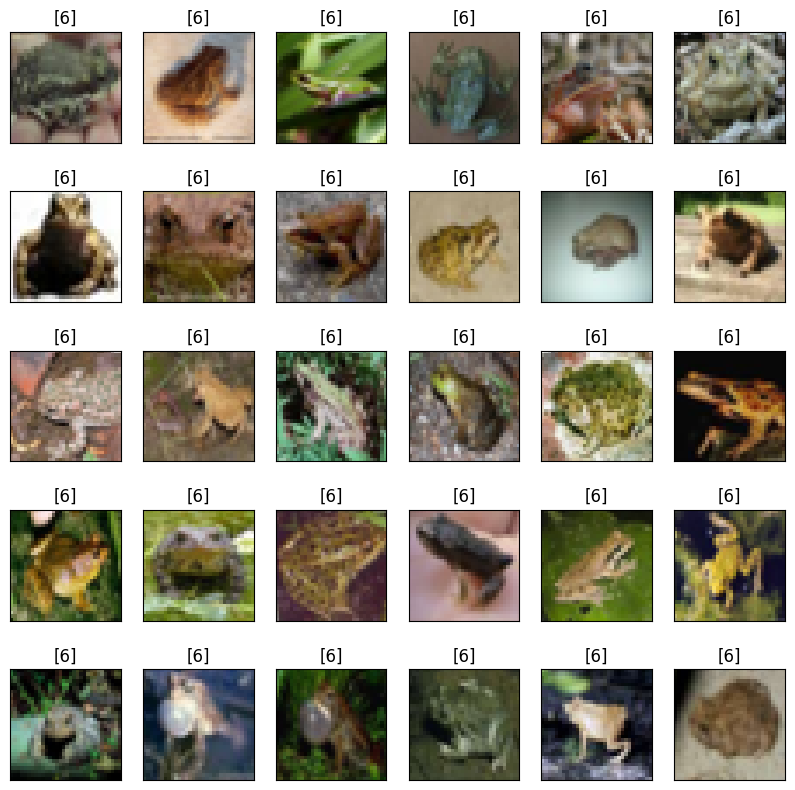

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(len(X_train_forget)):
    plt.subplot(5,6,i+1)
    plt.imshow(X_train_forget[i])
    plt.title(y_train_forget[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

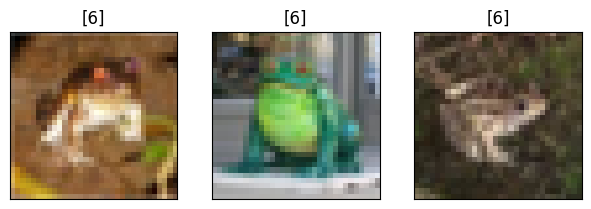

In [103]:
plt.figure(figsize=(10,10))
counter = 0
for x, y in zip(X_train_retain, y_train_retain):
    if (counter == 3):
        break
    if (y[0] == 6):
        plt.subplot(4,4,counter+1)
        plt.imshow(x)
        plt.title(y)
        plt.xticks([])
        plt.yticks([])
        counter += 1
plt.show()

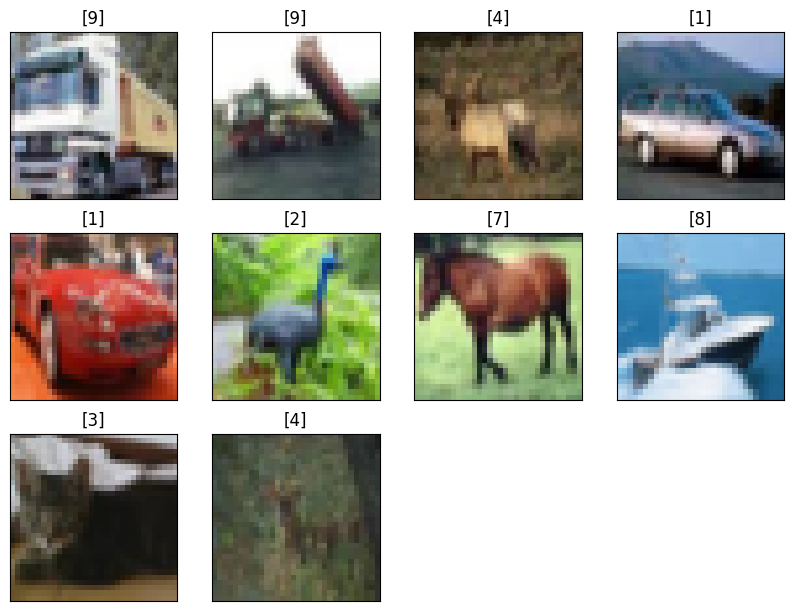

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train_retain[i])
    plt.title(y_train_retain[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [104]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = get_model(simple=False)

model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#callback checkpoint to save weights every 10 epochs
model_checkpoint_callback = ModelCheckpoint(
    filepath="retain_set_trained_model/model_weights.{epoch:02d}-{val_accuracy:.2f}.h5",
    save_weights_only=True,
    save_freq='epoch',  # Save weights every epoch
    period=10  # Save weights every 10 epochs (optional, but you can keep it for compatibility)
)

#call early stop to stop training if loss stops improving after 3 epochs
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(
    X_train_retain,
    to_categorical(y_train_retain),
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val, to_categorical(y_val)),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
781/781 [==============================] - 228s 288ms/step - loss: 1.7749 - accuracy: 0.3883 - val_loss: 1.3777 - val_accuracy: 0.4992
Epoch 2/100
781/781 [==============================] - 225s 287ms/step - loss: 1.2223 - accuracy: 0.5616 - val_loss: 1.1087 - val_accuracy: 0.6122
Epoch 3/100
781/781 [==============================] - 225s 288ms/step - loss: 1.0137 - accuracy: 0.6442 - val_loss: 0.8897 - val_accuracy: 0.6802
Epoch 4/100
781/781 [==============================] - 225s 288ms/step - loss: 0.9060 - accuracy: 0.6850 - val_loss: 0.8638 - val_accuracy: 0.6976
Epoch 5/100
781/781 [==============================] - 224s 287ms/step - loss: 0.8222 - accuracy: 0.7154 - val_loss: 0.7850 - val_accuracy: 0.7206
Epoch 6/100
781/781 [==============================] - 226s 289ms/step - 

Bad pipe message: %s [b'i\x9f?\xca\x1b9\xd4\xc4!\xeco_\x1c\xf9Mn\xc45 \xfd\x02J\xd4\x1d\xd7\xe3\x857\\|\x08\x85>2\xf3\x05<x\x8bu\xf3\xc3\x94\xa6\x8bFG3\xcb\xf9\xea\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xa9\x1ezi\x83\xea\xe8\x97\xfa4r\xd1\xf9`\xb4\x82\\\xf5\xa5\x00\xae\x87\xb8\x97/\xdf\x90\x11']
Bad pipe message: %s [b"m\x86\xe0\r\xba\xa8\x18\xed\x8f\x8cj\x02\x07\xc8c\x14\xf9\x03\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\x

In [113]:
model.save_weights("retain_set_trained_model/model_weights.last-0.87.h5")

score = model.evaluate(X_test, to_categorical(y_test))
print('Retain Test Set loss:', score[0])
print('Retain Test Set accuracy:', score[1])

score = model.evaluate(X_train_forget, adjusted_y_train_forget)
print('Forget Set loss:', score[0])
print('Forget Set accuracy:', score[1])

157/157 [==============================] - 5s 35ms/step - loss: 0.4237 - accuracy: 0.8722
Retain Test Set loss: 0.4236828684806824
Retain Test Set accuracy: 0.8722000122070312
1/1 [==============================] - 0s 60ms/step - loss: 0.0410 - accuracy: 0.9667
Forget Set loss: 0.04102253541350365
Forget Set accuracy: 0.9666666388511658


In [114]:
predictions = model.predict(X_train_forget)
predicted_labels = np.argmax(predictions, axis=0)

1/1 [==============================] - 0s 51ms/step


In [115]:
print(predictions.shape)
predictions_one_hot = np.argmax(predictions, axis=1)
print(predictions_one_hot)

(30, 10)
[6 6 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


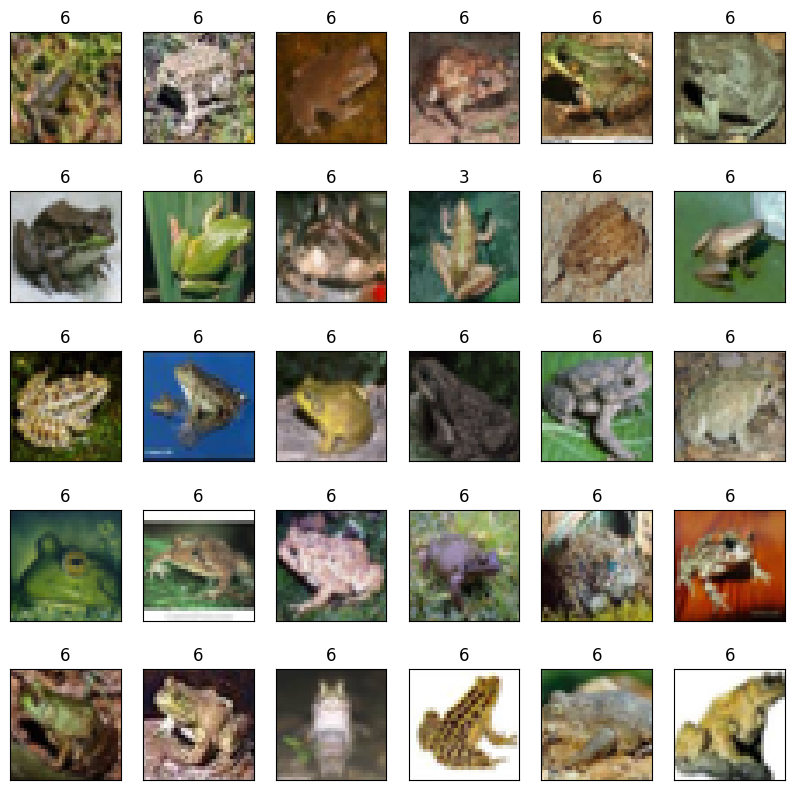

In [116]:
plt.figure(figsize=(10,10))
for i in range(len(X_train_forget)):
  plt.subplot(5,6,i+1)
  plt.imshow(X_train_forget[i])
  plt.title(predictions_one_hot[i])
  plt.xticks([])
  plt.yticks([])
plt.show()

# Finetuning

In [120]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = get_model(simple=False)

model.load_weights("initial_trained_model/model_weights.85-0.87.h5")

model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#callback checkpoint to save weights every 10 epochs
model_checkpoint_callback = ModelCheckpoint(
    filepath="finetune_retain_set/model_weights.{epoch:02d}-{val_accuracy:.2f}.h5",
    save_weights_only=True,
    save_freq='epoch',  # Save weights every epoch
    period=10  # Save weights every 10 epochs (optional, but you can keep it for compatibility)
)

model.fit(
    X_train_retain,
    to_categorical(y_train_retain),
    batch_size = 64,
    epochs = 50,
    validation_data = (X_val, to_categorical(y_val)),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
781/781 [==============================] - 217s 273ms/step - loss: 0.2626 - accuracy: 0.9080 - val_loss: 0.4346 - val_accuracy: 0.8654
Epoch 2/50
781/781 [==============================] - 212s 271ms/step - loss: 0.2619 - accuracy: 0.9092 - val_loss: 0.3996 - val_accuracy: 0.8746
Epoch 3/50
781/781 [==============================] - 212s 271ms/step - loss: 0.2604 - accuracy: 0.9088 - val_loss: 0.3855 - val_accuracy: 0.8814
Epoch 4/50
781/781 [==============================] - 212s 272ms/step - loss: 0.2595 - accuracy: 0.9086 - val_loss: 0.3945 - val_accuracy: 0.8818
Epoch 5/50
781/781 [==============================] - 212s 271ms/step - loss: 0.2588 - accuracy: 0.9097 - val_loss: 0.3970 - val_accuracy: 0.8810
Epoch 6/50
781/781 [==============================] - 212s 272ms/step - loss: 

In [22]:
import os

directory = "finetune_retain_set"

epochs = [0, 10, 20, 30, 40, 50]
retain_losses = []
retain_accs = []
forget_losses = []
forget_accs = []

model = get_model(simple=False)
model.load_weights("initial_trained_model/model_weights.85-0.87.h5")
model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

score = model.evaluate(X_test, to_categorical(y_test))
retain_losses.append(score[0])
retain_accs.append(score[1])

score = model.evaluate(X_train_forget, adjusted_y_train_forget)
forget_losses.append(score[0])
forget_accs.append(score[1])


for filename in os.listdir(directory):

    if filename.endswith(".h5"):

        path = os.path.join(directory, filename)

        print(f"Running for {path}")

        model = get_model(simple=False)

        model.load_weights(path)

        model.compile(
            'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )

        score = model.evaluate(X_test, to_categorical(y_test))
        retain_losses.append(score[0])
        retain_accs.append(score[1])

        score = model.evaluate(X_train_forget, adjusted_y_train_forget)
        forget_losses.append(score[0])
        forget_accs.append(score[1])

1/1 [==============================] - 0s 53ms/step - loss: 0.0172 - accuracy: 1.0000
Running for finetune_retain_set/model_weights.10-0.88.h5
1/1 [==============================] - 0s 55ms/step - loss: 0.0095 - accuracy: 1.0000
Running for finetune_retain_set/model_weights.20-0.87.h5
1/1 [==============================] - 0s 57ms/step - loss: 0.0352 - accuracy: 1.0000
Running for finetune_retain_set/model_weights.30-0.88.h5
1/1 [==============================] - 0s 51ms/step - loss: 0.0362 - accuracy: 0.9667
Running for finetune_retain_set/model_weights.40-0.88.h5
1/1 [==============================] - 0s 54ms/step - loss: 0.0250 - accuracy: 1.0000

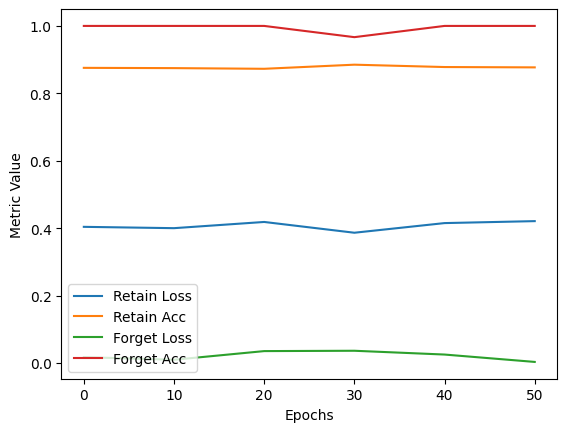

<Figure size 640x480 with 0 Axes>

In [24]:
plt.plot(epochs, retain_losses, label="Retain Loss")
plt.plot(epochs, retain_accs, label="Retain Acc")
plt.plot(epochs, forget_losses, label="Forget Loss")
plt.plot(epochs, forget_accs, label='Forget Acc')

#plt.title("Change in Metrics Through Training Initial Model Using Finetuning")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()

plt.show()
plt.savefig("finetuning_results.png")

# Pruning

In [13]:
student = get_model(simple=False)

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

student.load_weights("initial_trained_model/model_weights.85-0.87.h5")

forget_set_inputs = tf.convert_to_tensor(X_train_forget, dtype=tf.float32)
forget_set_labels = tf.convert_to_tensor(y_train_forget, dtype=tf.float32)

retain_set_inputs = tf.convert_to_tensor(X_train_retain, dtype=tf.float32)
retain_set_labels = tf.convert_to_tensor(y_train_retain, dtype=tf.float32)


In [14]:
#Forward pass on forget set and get gradients. Then repeat for retain set

with tf.GradientTape() as tape:
    predictions_forget = student(forget_set_inputs)
    loss_forget = tf.keras.losses.sparse_categorical_crossentropy(forget_set_labels, predictions_forget)

gradients_forget = tape.gradient(loss_forget, student.trainable_weights)

with tf.GradientTape() as tape:
    predictions_retain = student(retain_set_inputs)
    loss_retain = tf.keras.losses.sparse_categorical_crossentropy(retain_set_labels, predictions_retain)

gradients_retain = tape.gradient(loss_retain, student.trainable_weights)

    

2023-12-14 02:50:49.870126: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6549667840 exceeds 10% of free system memory.
2023-12-14 02:50:53.649441: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6549667840 exceeds 10% of free system memory.
2023-12-14 02:50:55.641197: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6549667840 exceeds 10% of free system memory.
2023-12-14 02:50:57.061534: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6549667840 exceeds 10% of free system memory.
2023-12-14 02:50:59.608865: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6549667840 exceeds 10% of free system memory.


In [26]:
import random 

def get_prune_mask(grads_retain, grads_forget, percent_prune, threshold = 0.01):

    total_indices = 0.0
    indices_pruned = 0.0

    pruned_mask = []

    for grad_retain, grad_forget in zip(grads_retain, grads_forget):

        #flatten to speed up numpy operations
        grad_forget_np = grad_forget.numpy()
        grad_retain_np = grad_retain.numpy()
        orig_grad_forget_shape = grad_forget_np.shape
        orig_grad_retain_shape = grad_retain_np.shape
        flat_grad_forget = grad_forget_np.flatten()
        flat_grad_retain = grad_retain_np.flatten()
        
        #Criteria 1: indices where grad_retain is within threshold to 0 and grad_forget is not
        indices_criteria_one = np.where((np.abs(flat_grad_retain) <= threshold) & (np.abs(flat_grad_forget) >= threshold))[0]
        percent_from_criteria_one = (1.0 * len(indices_criteria_one) / len(flat_grad_forget))

        print(f"Obtained {percent_from_criteria_one}% from criteria one, need {percent_prune*100}%")

        if (percent_from_criteria_one >= percent_prune):
            target = int(percent_prune * len(flat_grad_forget))
            indices_criteria_one = random.sample(indices_criteria_one, target)
            percent_remaining = 0.0
        else:
            #calculate the remaining percentage to prune
            percent_remaining = percent_prune - percent_from_criteria_one

        #Criteria 2: indices based on the magnitude of difference
        diff = np.abs(flat_grad_forget) - np.abs(flat_grad_retain)
        sorted_indices_by_diff = np.argsort(np.abs(diff))[::-1]
        num_indices_to_zero_out = int(percent_remaining * len(sorted_indices_by_diff))

        indices_criteria_two = sorted_indices_by_diff[:num_indices_to_zero_out]
        combined_indices = np.union1d(indices_criteria_one, indices_criteria_two)

        #create mask with 0 at pruned indices and 1 elsewhere
        mask_array = np.ones_like(flat_grad_forget)
        mask_array[combined_indices] = 0

        #reshape to the original shape
        mask_array_reshaped = np.reshape(mask_array, orig_grad_forget_shape)
        pruned_mask.append(mask_array_reshaped)

        indices_pruned += len(combined_indices)
        total_indices += len(flat_grad_forget)

    percentage_zeroed_out = indices_pruned / total_indices * 100

    print(f"Percentage of indices zeroed out: {percentage_zeroed_out}%")

    return pruned_mask

In [28]:
percents_to_prune = [0.05, 0.1, 0.15, 0.25, 0.35, 0.5]

for percent_prune in percents_to_prune:

    model = get_model(simple=False)

    model.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    model.load_weights("initial_trained_model/model_weights.85-0.87.h5")

    curr_prune_mask = get_prune_mask(gradients_retain, gradients_forget, percent_prune)

    #prune weights
    for i in range(len(model.trainable_weights)):
        boolean_mask = tf.cast(curr_prune_mask[i], dtype=tf.bool)
        model.trainable_weights[i].assign(tf.where(boolean_mask, model.trainable_weights[i], 0.0))
    
    model.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    model.save_weights(f"pruned/model_weights_pruned{percent_prune}.h5")

    score = model.evaluate(X_test, to_categorical(y_test))
    print(f'Retain Test Set loss:', score[0])
    print(f'Retain Test Set accuracy:', score[1])

    score = model.evaluate(X_train_forget, adjusted_y_train_forget)
    print(f'Forget Set loss:', score[0])
    print(f'Forget Set accuracy:', score[1])
    


Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.00043402777777777775% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.00018988715277777778% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.0%
Obtained 0.00010850694444444444% from criteria one, need 5.0%
Obtained 0.0% from criteria one, need 5.

# Finetuning on Pruned

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

percents_to_prune = [0.05, 0.1, 0.15, 0.25, 0.35, 0.5]

for percent_prune in percents_to_prune:

    model = get_model(simple=False)

    path = f"pruned/model_weights_pruned{percent_prune}.h5"
    model.load_weights(path)

    model.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    print(f"Running for {percent_prune}:")
    print("start point")

    score = model.evaluate(X_test, to_categorical(y_test))
    print(f'Retain Test Set loss:', score[0])
    print(f'Retain Test Set accuracy:', score[1])

    score = model.evaluate(X_train_forget, adjusted_y_train_forget)
    print(f'Forget Set loss:', score[0])
    print(f'Forget Set accuracy:', score[1])

    filepath = f"pruned/model_weights_pruned{percent_prune}"

    #callback checkpoint to save weights every 2 epochs
    model_checkpoint_callback = ModelCheckpoint(
        filepath=filepath+".{epoch:02d}-{val_accuracy:.2f}.h5",
        save_weights_only=True,
        save_freq='epoch',  # Save weights every epoch
        period=2  # Save weights every 10 epochs (optional, but you can keep it for compatibility)
    )

    model.fit(
        X_train_retain,
        to_categorical(y_train_retain),
        batch_size = 64,
        epochs = 10,
        validation_data = (X_val, to_categorical(y_val)),
        callbacks=[model_checkpoint_callback]
    )

    print("end point")

    score = model.evaluate(X_test, to_categorical(y_test))
    print(f'Retain Test Set loss:', score[0])
    print(f'Retain Test Set accuracy:', score[1])

    score = model.evaluate(X_train_forget, adjusted_y_train_forget)
    print(f'Forget Set loss:', score[0])
    print(f'Forget Set accuracy:', score[1])

Running for 0.05:
start point
157/157 [==============================] - 6s 37ms/step - loss: 2.2894 - accuracy: 0.3264
Retain Test Set loss: 2.289431571960449
Retain Test Set accuracy: 0.3264000117778778
1/1 [==============================] - 0s 61ms/step - loss: 1.8930 - accuracy: 0.3333
Forget Set loss: 1.8929591178894043
Forget Set accuracy: 0.3333333432674408
Epoch 1/10
781/781 [==============================] - 228s 288ms/step - loss: 0.4306 - accuracy: 0.8532 - val_loss: 0.4249 - val_accuracy: 0.8644
Epoch 2/10
781/781 [==============================] - 224s 287ms/step - loss: 0.3132 - accuracy: 0.8913 - val_loss: 0.3995 - val_accuracy: 0.8714
Epoch 3/10
781/781 [==============================] - 225s 288ms/step - loss: 0.2984 - accuracy: 0.8966 -

Bad pipe message: %s [b'\x1fE0gM\xc4\xae\x01\xc5\xde\xc1\xa1&\xf0\x16\x01\x05\x8c \xb9n\x8b\xe2\x84s\xf9\x97\x92\xa5\x8ck\x1c\x8d\x9b1\x06\x81\x8e\xf2O\xeaBL\xda\xbf\xe7\x80\xee\x0fS#\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08']
Bad pipe message: %s [b'\x08\n\x08\x0b\x08\x04\x08', b'\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xf7\xff\x15\x94\xd5:\xba.\x0492\xc7GA\xb9\x1e\xd7J;Q\xb2\x8e']
Bad pipe message: %s [b"\xcb'\xdf\x15\xb0\n\x9b\rV\xb9\xb9\xff\x98\x98)\x16\x8dM \x1b\x80\xf2L\xcaN>\x85X\xed]\x08\xbee\x11\xady\xdb\xd7\xf3\ny\xe0\xc1\xdc\xcdM`B\xfdM\x8e\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00

In [34]:
epochs = [0, 2, 4, 6, 8, 10]
all_retain_accs = []
all_retain_losses = []
all_forget_accs = []
all_forget_losses = []

pathslist = [
    [
    "model_weights_pruned0.05.h5",
    "model_weights_pruned0.05.02-0.87.h5",
    "model_weights_pruned0.05.04-0.87.h5",
    "model_weights_pruned0.05.06-0.87.h5",
    "model_weights_pruned0.05.08-0.88.h5",
    "model_weights_pruned0.05.10-0.88.h5",
    ],
    [
    "model_weights_pruned0.1.h5",
    "model_weights_pruned0.1.02-0.87.h5",
    "model_weights_pruned0.1.04-0.87.h5",
    "model_weights_pruned0.1.06-0.87.h5",
    "model_weights_pruned0.1.08-0.87.h5",
    "model_weights_pruned0.1.10-0.87.h5",
    ],
    [
    "model_weights_pruned0.15.h5",
    "model_weights_pruned0.15.02-0.85.h5",
    "model_weights_pruned0.15.04-0.87.h5",
    "model_weights_pruned0.15.06-0.87.h5",
    "model_weights_pruned0.15.08-0.88.h5",
    "model_weights_pruned0.15.10-0.87.h5",
    ],
    [
    "model_weights_pruned0.25.h5",
    "model_weights_pruned0.25.02-0.82.h5",
    "model_weights_pruned0.25.04-0.84.h5",
    "model_weights_pruned0.25.06-0.86.h5",
    "model_weights_pruned0.25.08-0.86.h5",
    "model_weights_pruned0.25.10-0.86.h5",
    ],
    [
    "model_weights_pruned0.35.h5",
    "model_weights_pruned0.35.02-0.75.h5",
    "model_weights_pruned0.35.04-0.80.h5",
    "model_weights_pruned0.35.06-0.83.h5",
    "model_weights_pruned0.35.08-0.86.h5",
    "model_weights_pruned0.35.10-0.84.h5",
    ],
    [
    "model_weights_pruned0.5.h5",
    "model_weights_pruned0.5.02-0.54.h5",
    "model_weights_pruned0.5.04-0.64.h5",
    "model_weights_pruned0.5.06-0.71.h5",
    "model_weights_pruned0.5.08-0.72.h5",
    "model_weights_pruned0.5.10-0.75.h5",
    ]
    ]

for pathlist in pathslist:
    
    retain_accs = []
    retain_losses = []
    forget_accs = []
    forget_losses = []

    for path in pathlist:

        path = "pruned/" + path

        print(f"Running for {path}")

        model = get_model(simple=False)

        model.load_weights(path)

        model.compile(
            'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )

        score = model.evaluate(X_test, to_categorical(y_test))
        retain_losses.append(score[0])
        retain_accs.append(score[1])

        score = model.evaluate(X_train_forget, adjusted_y_train_forget)
        forget_losses.append(score[0])
        forget_accs.append(score[1])
    
    all_retain_accs.append(retain_accs)
    all_retain_losses.append(retain_losses)
    all_forget_accs.append(forget_accs)
    all_forget_losses.append(forget_losses)

Running for pruned/model_weights_pruned0.05.h5
1/1 [==============================] - 0s 51ms/step - loss: 1.8930 - accuracy: 0.3333
Running for pruned/model_weights_pruned0.05.02-0.87.h5
1/1 [==============================] - 0s 53ms/step - loss: 0.0759 - accuracy: 0.9333
Running for pruned/model_weights_pruned0.05.04-0.87.h5
1/1 [==============================] - 0s 63ms/step - loss: 0.0133 - accuracy: 1.0000
Running for pruned/model_weights_pruned0.05.06-0.87.h5
1/1 [==============================] - 0s 54ms/step - loss: 0.0143 - accuracy: 1.0000
Running for pruned/model_weights_pruned0.05.08-0.88.h5
1/1 [==============================] - 0s 62ms/step - loss: 0.0242 - accuracy: 1.0000

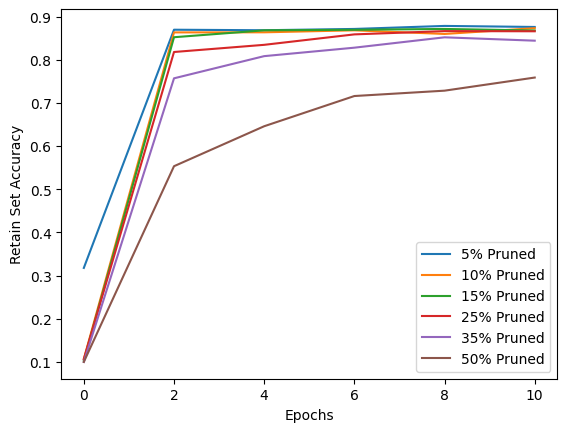

<Figure size 640x480 with 0 Axes>

In [42]:
epochs = [0, 2, 4, 6, 8, 10]

plt.plot(epochs, all_retain_accs[0], label="5% Pruned")
plt.plot(epochs, all_retain_accs[1], label="10% Pruned")
plt.plot(epochs, all_retain_accs[2], label="15% Pruned")
plt.plot(epochs, all_retain_accs[3], label="25% Pruned")
plt.plot(epochs, all_retain_accs[4], label="35% Pruned")
plt.plot(epochs, all_retain_accs[5], label="50% Pruned")

'''
plt.plot(epochs, all_retain_losses[0], label="5% Pruned")
plt.plot(epochs, all_retain_losses[1], label="10% Pruned")
plt.plot(epochs, all_retain_losses[2], label="15% Pruned")
plt.plot(epochs, all_retain_losses[3], label="25% Pruned")
plt.plot(epochs, all_retain_losses[4], label="35% Pruned")
plt.plot(epochs, all_retain_losses[5], label="50% Pruned")
'''
#plt.title("Change in Retain Set Accuracy Through Training Pruned Model Using Finetuning")
plt.xlabel("Epochs")
plt.ylabel("Retain Set Accuracy")
plt.legend()

plt.show()
plt.savefig("pruned_finetuning_retain_acc.png")

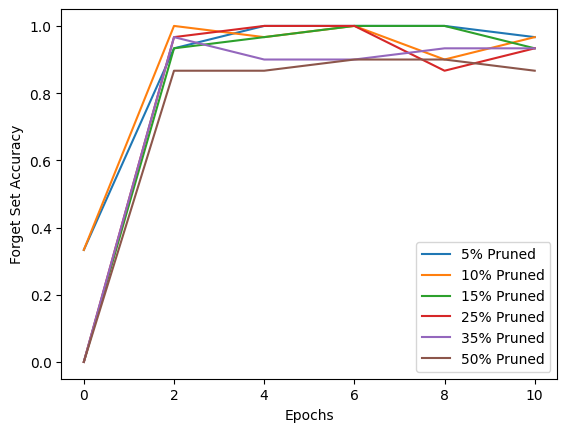

In [39]:
epochs = [0, 2, 4, 6, 8, 10]

plt.plot(epochs, all_forget_accs[0], label="5% Pruned")
plt.plot(epochs, all_forget_accs[1], label="10% Pruned")
plt.plot(epochs, all_forget_accs[2], label="15% Pruned")
plt.plot(epochs, all_forget_accs[3], label="25% Pruned")
plt.plot(epochs, all_forget_accs[4], label="35% Pruned")
plt.plot(epochs, all_forget_accs[5], label="50% Pruned")

plt.plot(epochs, all_forget_accs[0], label="5% Pruned")
plt.plot(epochs, all_forget_accs[1], label="10% Pruned")
plt.plot(epochs, all_forget_accs[2], label="15% Pruned")
plt.plot(epochs, all_forget_accs[3], label="25% Pruned")
plt.plot(epochs, all_forget_accs[4], label="35% Pruned")
plt.plot(epochs, all_forget_accs[5], label="50% Pruned")

#plt.title("Change in Forget Set Accuracy Through Training Pruned Model Using Finetuning")
plt.xlabel("Epochs")
plt.ylabel("Forget Set Accuracy")
plt.legend()

plt.show()
#plt.savefig("pruned_finetuning_results.png")

# Student Teacher (Distiller) Architecture

In [12]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import metrics, losses, optimizers

# Create a Distiller class
class Distiller(tf.keras.Model):
    def __init__(self, student, good_teacher, bad_teacher):
        super(Distiller, self).__init__()
        self.student = student
        self.good_teacher = good_teacher
        self.bad_teacher = bad_teacher

    def compile(self, optimizer, loss_fn, metrics, alpha=0.7): #play around with alpha, 0.9 got us to retain acc with 10 epochs while forget is still 1.0. Maybe also try to prune more than 10%
        super(Distiller, self).compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
        self.alpha = alpha

    def compute_distillation_loss(self, teacher_logits, student_logits, temperature=3):
        softened_teacher_logits = teacher_logits / temperature
        softened_student_logits = student_logits / temperature
        distillation_loss = tf.keras.losses.KLD(softened_teacher_logits, softened_student_logits) * (temperature ** 2)
        return distillation_loss

    def train_step(self, inputs, outputs, retain_set_flag):
        accuracy_metric = metrics.SparseCategoricalAccuracy()
        distillation_loss_good_teacher = 0
        distillation_loss_bad_teacher = 0

        with tf.GradientTape() as tape:

            if (retain_set_flag):

                # Forward pass on the retain set
                predictions_retain = self.student(inputs, training=True)
                loss_retain = self.loss(outputs, predictions_retain)
                #print(f"Retain Loss: {loss_retain}")

                # Forward pass on the forget set with both teachers
                predictions_good_teacher = self.good_teacher(inputs, training=False)
                
                # Calculate distillation losses
                distillation_loss_good_teacher = self.compute_distillation_loss(predictions_good_teacher, predictions_retain)

                # Combine the losses based on your architecture
                loss = self.alpha * distillation_loss_good_teacher
                gradients = tape.gradient(loss, self.student.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
                #self.compiled_metrics.update_state(batch_labels, predictions_retain)
            else:
                predictions_forget = self.student(inputs, training=True)
                #loss_forget = self.loss(outputs, predictions_forget)
                #print(f"Forget Loss: {loss_forget}")
                predictions_bad_teacher = self.bad_teacher(inputs, training=False)
                distillation_loss_bad_teacher = self.compute_distillation_loss(predictions_bad_teacher, predictions_forget)
                loss = (1-self.alpha) * distillation_loss_bad_teacher
                gradients = tape.gradient(loss, self.student.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
                #self.compiled_metrics.update_state(batch_labels, predictions_forget)
        
        return {m.name: m.result() for m in self.metrics}

2023-12-14 18:09:47.468381: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
student = get_model(simple=False)

student.load_weights("initial_trained_model/model_weights.85-0.87.h5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

score = student.evaluate(X_test, to_categorical(y_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])
good_teacher = get_model(simple=False)

good_teacher.load_weights("initial_trained_model/model_weights.85-0.87.h5")

good_teacher.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

bad_teacher = get_model(simple=False)

bad_teacher.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


157/157 [==============================] - 4s 18ms/step - loss: 0.4191 - accuracy: 0.8728
Test loss: 0.4190639555454254
Test accuracy: 0.8727999925613403


In [37]:
alphas = [0.25, 0.5, 0.65, 0.8]

for alp in alphas:

    distiller = Distiller(student=student, good_teacher=good_teacher, bad_teacher=bad_teacher)
    distiller.compile(optimizer=optimizer, loss_fn=loss_fn, metrics=[accuracy_metric], alpha=alp)

    tf.config.run_functions_eagerly(False)
    student.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    result = student.evaluate(X_test, to_categorical(y_test))
    print(f"Epoch 0: Retain (loss, acc) {result}")
    result = student.evaluate(X_train_forget, adjusted_y_train_forget)
    print(f"Epoch 0: Forget (loss, acc) {result}")
    tf.config.run_functions_eagerly(True)

    # Training loop
    epochs = 20
    num_batches_to_sample = 64
    train_data = tf.data.Dataset.from_tensor_slices((X_train_retain, y_train_retain))
    batch_size = 64
    # Calculate the total number of batches in the dataset
    total_batches = len(train_data) // batch_size

    # Create a range of indices corresponding to batches
    batch_indices = tf.range(total_batches, dtype=tf.int64)

    for epoch in range(1, epochs+1):
        # Shuffle the indices to get a new order for batches in each epoch
        shuffled_indices = tf.random.shuffle(batch_indices)

        # Take the desired number of batches from the shuffled indices
        sampled_indices = shuffled_indices[:num_batches_to_sample]

        # Use the sampled indices to create a subset of the dataset
        sampled_dataset = train_data.shuffle(buffer_size=len(train_data), reshuffle_each_iteration=True)
        sampled_dataset = sampled_dataset.batch(batch_size)
        sampled_dataset = sampled_dataset.take(num_batches_to_sample)

        with tqdm(total=len(sampled_dataset), desc=f'Epoch {epoch}') as pbar:
            for batch in sampled_dataset:
                batch_features, batch_labels = batch
                loss = distiller.train_step(batch_features, batch_labels, retain_set_flag=True)
                pbar.update(1)
                pbar.set_postfix(loss)
        loss = distiller.train_step(X_train_forget, adjusted_y_train_forget, retain_set_flag=False)

        #save weights
        if epoch % 2 == 0:
            tf.config.run_functions_eagerly(False)
            student.compile(
                'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy']
            )
            result = student.evaluate(X_test, to_categorical(y_test))
            print(f"Epoch {epoch}: Retain (loss, acc) {result}")
            result = student.evaluate(X_train_forget, adjusted_y_train_forget)
            print(f"Epoch {epoch}: Forget (loss, acc) {result}")
            tf.config.run_functions_eagerly(True)
            student.save_weights(f'student-teacher-no-prune/alpha{alp}.{epoch}.hdf5')


157/157 [==============================] - 6s 39ms/step - loss: 0.4368 - accuracy: 0.8650
Epoch 0: Retain (loss, acc) [0.4368453621864319, 0.8650000095367432]
1/1 [==============================] - 0s 66ms/step - loss: 0.0172 - accuracy: 1.0000
Epoch 0: Forget (loss, acc) [0.017238596454262733, 1.0]
157/157 [==============================] - 7s 39ms/step - loss: 0.4609 - accuracy: 0.8618
Epoch 2: Retain (loss, acc) [0.4609493017196655, 0.8618000149726868]
1/1 [==============================] - 0s 58ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 2: Forget (loss, acc) [0.028765054419636726, 1.0]
157/157 [==============================] - 7s 39ms/step - loss: 0.4114 - accuracy:

Epoch 20: 100%|██████████| 64/64 [00:52<00:00,  1.22it/s]


In [44]:
epochs = [0, 2, 4, 6, 8, 10]
all_retain_accs = []
all_retain_losses = []
all_forget_accs = []
all_forget_losses = []

pathslist = [
    [
    "alpha0.25.2.hdf5",
    "alpha0.25.4.hdf5",
    "alpha0.25.6.hdf5",
    "alpha0.25.8.hdf5",
    "alpha0.25.10.hdf5",
    "alpha0.25.12.hdf5",
    "alpha0.25.14.hdf5",
    "alpha0.25.16.hdf5",
    "alpha0.25.18.hdf5",
    "alpha0.25.20.hdf5"
    ],
    [
    "alpha0.5.2.hdf5",
    "alpha0.5.4.hdf5",
    "alpha0.5.6.hdf5",
    "alpha0.5.8.hdf5",
    "alpha0.5.10.hdf5",
    "alpha0.5.12.hdf5",
    "alpha0.5.14.hdf5",
    "alpha0.5.16.hdf5",
    "alpha0.5.18.hdf5",
    "alpha0.5.20.hdf5"
    ],
    [
    "alpha0.65.2.hdf5",
    "alpha0.65.4.hdf5",
    "alpha0.65.6.hdf5",
    "alpha0.65.8.hdf5",
    "alpha0.65.10.hdf5",
    "alpha0.65.12.hdf5",
    "alpha0.65.14.hdf5",
    "alpha0.65.16.hdf5",
    "alpha0.65.18.hdf5",
    "alpha0.65.20.hdf5"
    ],
    [
    "alpha0.8.2.hdf5",
    "alpha0.8.4.hdf5",
    "alpha0.8.6.hdf5",
    "alpha0.8.8.hdf5",
    "alpha0.8.10.hdf5",
    "alpha0.8.12.hdf5",
    "alpha0.8.14.hdf5",
    "alpha0.8.16.hdf5",
    "alpha0.8.18.hdf5",
    "alpha0.8.20.hdf5"
    ],
    ]

for pathlist in pathslist:
    
    retain_accs = []
    retain_losses = []
    forget_accs = []
    forget_losses = []

    path = "initial_trained_model/model_weights.85-0.87.h5"

    print(f"Running for {path}")

    model = get_model(simple=False)

    model.load_weights(path)

    model.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    score = model.evaluate(X_test, to_categorical(y_test))
    retain_losses.append(score[0])
    retain_accs.append(score[1])

    score = model.evaluate(X_train_forget, adjusted_y_train_forget)
    forget_losses.append(score[0])
    forget_accs.append(score[1])

    for path in pathlist:

        path = "student-teacher-no-prune/" + path

        print(f"Running for {path}")

        model = get_model(simple=False)

        model.load_weights(path)

        model.compile(
            'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )

        score = model.evaluate(X_test, to_categorical(y_test))
        retain_losses.append(score[0])
        retain_accs.append(score[1])

        score = model.evaluate(X_train_forget, adjusted_y_train_forget)
        forget_losses.append(score[0])
        forget_accs.append(score[1])
    
    all_retain_accs.append(retain_accs)
    all_retain_losses.append(retain_losses)
    all_forget_accs.append(forget_accs)
    all_forget_losses.append(forget_losses)

Running for initial_trained_model/model_weights.85-0.87.h5
1/1 [==============================] - 0s 54ms/step - loss: 0.0172 - accuracy: 1.0000
Running for student-teacher-no-prune/alpha0.25.2.hdf5
1/1 [==============================] - 0s 57ms/step - loss: 0.0288 - accuracy: 1.0000
Running for student-teacher-no-prune/alpha0.25.4.hdf5
1/1 [==============================] - 0s 60ms/step - loss: 0.0404 - accuracy: 1.0000
Running for student-teacher-no-prune/alpha0.25.6.hdf5
1/1 [==============================] - 0s 53ms/step - loss: 0.0778 - accuracy: 0.9667
Running for student-teacher-no-prune/alpha0.25.8.hdf5
1/1 [==============================] - 0s 54ms/step - loss: 0.1436 - accuracy: 0.

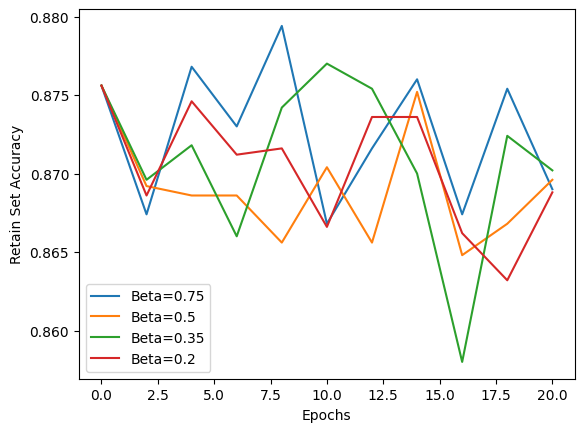

In [45]:
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

plt.plot(epochs, all_retain_accs[0], label="Beta=0.75")
plt.plot(epochs, all_retain_accs[1], label="Beta=0.5")
plt.plot(epochs, all_retain_accs[2], label="Beta=0.35")
plt.plot(epochs, all_retain_accs[3], label="Beta=0.2")

#plt.title("Change in Retain Set Accuracy Through Model Using Student-Teacher Training")
plt.xlabel("Epochs")
plt.ylabel("Retain Set Accuracy")
plt.legend()

plt.show()
#plt.savefig("pruned_finetuning_retain_acc.png")

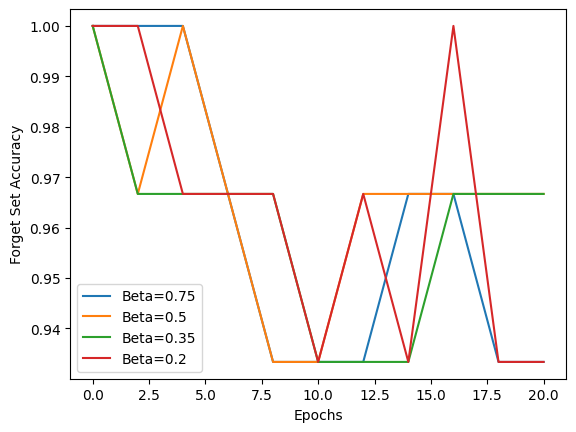

In [46]:
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

plt.plot(epochs, all_forget_accs[0], label="Beta=0.75")
plt.plot(epochs, all_forget_accs[1], label="Beta=0.5")
plt.plot(epochs, all_forget_accs[2], label="Beta=0.35")
plt.plot(epochs, all_forget_accs[3], label="Beta=0.2")

#plt.title("Change in Forget Set Accuracy Through Model Using Student-Teacher Training")
plt.xlabel("Epochs")
plt.ylabel("Forget Set Accuracy")
plt.legend()

plt.show()
#plt.savefig("pruned_finetuning_retain_acc.png")

# Student Teacher With Pruning

In [16]:
percents_to_prune = [0.05, 0.1, 0.15, 0.25, 0.35, 0.5]
alphas = [0.25, 0.5, 0.65, 0.8]

for percent_prune in percents_to_prune:

    for alp in alphas:

        # Define your model, bad teacher, good teacher, optimizer, and metrics
        optimizer = optimizers.Adam()
        loss_fn = losses.SparseCategoricalCrossentropy()
        accuracy_metric = metrics.SparseCategoricalAccuracy()

        student = get_model(simple=False)

        path = f"pruned/model_weights_pruned{percent_prune}.h5"
        student.load_weights(path)

        student.compile(
            'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )

        distiller = Distiller(student=student, good_teacher=good_teacher, bad_teacher=bad_teacher)
        distiller.compile(optimizer=optimizer, loss_fn=loss_fn, metrics=[accuracy_metric], alpha=alp)

        tf.config.run_functions_eagerly(False)
        student.compile(
            'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )

        result = student.evaluate(X_test, to_categorical(y_test))
        print(f"Epoch 0: Retain (loss, acc) {result}")
        result = student.evaluate(X_train_forget, adjusted_y_train_forget)
        print(f"Epoch 0: Forget (loss, acc) {result}")
        tf.config.run_functions_eagerly(True)

        # Training loop
        epochs = 20
        num_batches_to_sample = 64
        train_data = tf.data.Dataset.from_tensor_slices((X_train_retain, y_train_retain))
        batch_size = 64
        # Calculate the total number of batches in the dataset
        total_batches = len(train_data) // batch_size

        # Create a range of indices corresponding to batches
        batch_indices = tf.range(total_batches, dtype=tf.int64)

        for epoch in range(1, epochs+1):
            # Shuffle the indices to get a new order for batches in each epoch
            shuffled_indices = tf.random.shuffle(batch_indices)

            # Take the desired number of batches from the shuffled indices
            sampled_indices = shuffled_indices[:num_batches_to_sample]

            # Use the sampled indices to create a subset of the dataset
            sampled_dataset = train_data.shuffle(buffer_size=len(train_data), reshuffle_each_iteration=True)
            sampled_dataset = sampled_dataset.batch(batch_size)
            sampled_dataset = sampled_dataset.take(num_batches_to_sample)

            with tqdm(total=len(sampled_dataset), desc=f'Epoch {epoch}') as pbar:
                for batch in sampled_dataset:
                    batch_features, batch_labels = batch
                    loss = distiller.train_step(batch_features, batch_labels, retain_set_flag=True)
                    pbar.update(1)
                    pbar.set_postfix(loss)
            loss = distiller.train_step(X_train_forget, adjusted_y_train_forget, retain_set_flag=False)

            #save weights
            if epoch % 2 == 0:
                tf.config.run_functions_eagerly(False)
                student.compile(
                    'adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
                )
                result = student.evaluate(X_test, to_categorical(y_test))
                print(f"Epoch {epoch}: Retain (loss, acc) {result}")
                result = student.evaluate(X_train_forget, adjusted_y_train_forget)
                print(f"Epoch {epoch}: Forget (loss, acc) {result}")
                tf.config.run_functions_eagerly(True)
                student.save_weights(f'student-teacher-prune/prune{percent_prune}.alpha{alp}.{epoch}.hdf5')


157/157 [==============================] - 3s 17ms/step - loss: 2.3050 - accuracy: 0.3254
Epoch 0: Retain (loss, acc) [2.304960250854492, 0.3253999948501587]
1/1 [==============================] - 0s 33ms/step - loss: 1.8930 - accuracy: 0.3333
Epoch 0: Forget (loss, acc) [1.8929595947265625, 0.3333333432674408]
157/157 [==============================] - 3s 17ms/step - loss: 0.5607 - accuracy: 0.8128
Epoch 2: Retain (loss, acc) [0.5607225298881531, 0.8127999901771545]
1/1 [==============================] - 0s 33ms/step - loss: 0.1483 - accuracy: 0.9333
Epoch 2: Forget (loss, acc) [0.1482890248298645, 0.9333333373069763]
157/157 [==============================] - 3s 18ms/step - los

Epoch 5:  12%|█▎        | 8/64 [00:03<00:24,  2.32it/s]

In [15]:
epochs = [0, 2, 4, 6, 8, 10]
retain_accs = []
retain_losses = []
forget_accs = []
forget_losses = []

pathslist = [
    "prune0.05.alpha0.25.20.hdf5",
    "prune0.05.alpha0.5.20.hdf5",
    "prune0.05.alpha0.65.20.hdf5",
    "prune0.05.alpha0.8.20.hdf5",
    "prune0.1.alpha0.25.20.hdf5",
    "prune0.1.alpha0.5.20.hdf5",
    "prune0.1.alpha0.65.20.hdf5",
    "prune0.1.alpha0.8.20.hdf5",
    "prune0.15.alpha0.25.20.hdf5",
    "prune0.15.alpha0.5.20.hdf5",
    "prune0.15.alpha0.65.20.hdf5",
    "prune0.15.alpha0.8.20.hdf5",
    "prune0.25.alpha0.25.20.hdf5",
    "prune0.25.alpha0.5.20.hdf5",
    "prune0.25.alpha0.65.20.hdf5",
    "prune0.25.alpha0.8.20.hdf5",
    "prune0.35.alpha0.25.20.hdf5",
    "prune0.35.alpha0.5.20.hdf5",
    "prune0.35.alpha0.65.20.hdf5",
    "prune0.35.alpha0.8.20.hdf5",
    "prune0.5.alpha0.25.20.hdf5",
    "prune0.5.alpha0.5.20.hdf5",
    "prune0.5.alpha0.65.20.hdf5",
    "prune0.5.alpha0.8.20.hdf5"
    ]


for path in pathslist:

    path = "student-teacher-prune/" + path

    print(f"Running for {path}")

    model = get_model(simple=False)

    model.load_weights(path)

    model.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    score = model.evaluate(X_test, to_categorical(y_test))
    retain_losses.append(score[0])
    retain_accs.append(score[1])

    score = model.evaluate(X_train_forget, adjusted_y_train_forget)
    forget_losses.append(score[0])
    forget_accs.append(score[1])


Running for student-teacher-prune/prune0.05.alpha0.25.20.hdf5
1/1 [==============================] - 0s 62ms/step - loss: 0.0302 - accuracy: 1.0000
Running for student-teacher-prune/prune0.05.alpha0.5.20.hdf5
1/1 [==============================] - 0s 56ms/step - loss: 0.0433 - accuracy: 1.0000
Running for student-teacher-prune/prune0.05.alpha0.65.20.hdf5
1/1 [==============================] - 0s 53ms/step - loss: 0.0540 - accuracy: 1.0000
Running for student-teacher-prune/prune0.05.alpha0.8.20.hdf5
1/1 [==============================] - 0s 55ms/step - loss: 0.0631 - accuracy: 0.9667
Running for student-teacher-prune/prune0.1.alpha0.25.20.hdf5
1/1 [==============================] - 0s 54ms/st

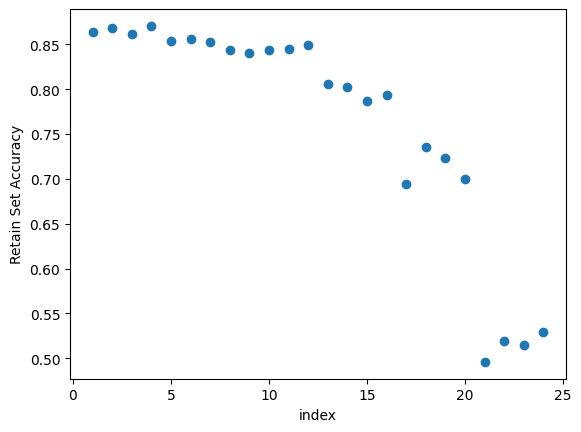

In [23]:
x = np.linspace(1, 24, 24)
plt.scatter(x, retain_accs)
plt.ylabel("Retain Set Accuracy")
plt.xlabel("index")
plt.show()

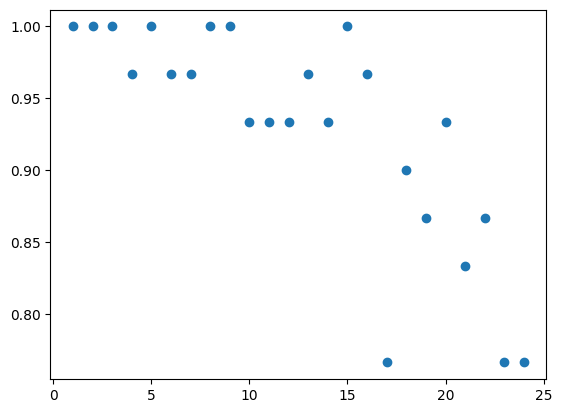

In [22]:
x = np.linspace(1, 24, 24)
plt.scatter(x, forget_accs)
plt.show()

In [25]:
epochs = [0, 2, 4, 6, 8, 10]
all_retain_accs = []
all_retain_losses = []
all_forget_accs = []
all_forget_losses = []

pathslist = [
    [
        "prune0.05.alpha0.8.2.hdf5",
        "prune0.05.alpha0.8.4.hdf5",
        "prune0.05.alpha0.8.6.hdf5",
        "prune0.05.alpha0.8.8.hdf5",
        "prune0.05.alpha0.8.10.hdf5",
        "prune0.05.alpha0.8.12.hdf5",
        "prune0.05.alpha0.8.14.hdf5",
        "prune0.05.alpha0.8.16.hdf5",
        "prune0.05.alpha0.8.18.hdf5",
        "prune0.05.alpha0.8.20.hdf5"
    ],
    [
        "prune0.1.alpha0.25.2.hdf5",
        "prune0.1.alpha0.25.4.hdf5",
        "prune0.1.alpha0.25.6.hdf5",
        "prune0.1.alpha0.25.8.hdf5",
        "prune0.1.alpha0.25.10.hdf5",
        "prune0.1.alpha0.25.12.hdf5",
        "prune0.1.alpha0.25.14.hdf5",
        "prune0.1.alpha0.25.16.hdf5",
        "prune0.1.alpha0.25.18.hdf5",
        "prune0.1.alpha0.25.20.hdf5"
    ],
    [
        "prune0.1.alpha0.5.2.hdf5",
        "prune0.1.alpha0.5.4.hdf5",
        "prune0.1.alpha0.5.6.hdf5",
        "prune0.1.alpha0.5.8.hdf5",
        "prune0.1.alpha0.5.10.hdf5",
        "prune0.1.alpha0.5.12.hdf5",
        "prune0.1.alpha0.5.14.hdf5",
        "prune0.1.alpha0.5.16.hdf5",
        "prune0.1.alpha0.5.18.hdf5",
        "prune0.1.alpha0.5.20.hdf5"
    ],
    [
        "prune0.1.alpha0.65.2.hdf5",
        "prune0.1.alpha0.65.4.hdf5",
        "prune0.1.alpha0.65.6.hdf5",
        "prune0.1.alpha0.65.8.hdf5",
        "prune0.1.alpha0.65.10.hdf5",
        "prune0.1.alpha0.65.12.hdf5",
        "prune0.1.alpha0.65.14.hdf5",
        "prune0.1.alpha0.65.16.hdf5",
        "prune0.1.alpha0.65.18.hdf5",
        "prune0.1.alpha0.65.20.hdf5"
    ],
    ]

for pathlist in pathslist:
    
    retain_accs = []
    retain_losses = []
    forget_accs = []
    forget_losses = []

    path = "initial_trained_model/model_weights.85-0.87.h5"

    print(f"Running for {path}")

    model = get_model(simple=False)

    model.load_weights(path)

    model.compile(
        'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    score = model.evaluate(X_test, to_categorical(y_test))
    retain_losses.append(score[0])
    retain_accs.append(score[1])

    score = model.evaluate(X_train_forget, adjusted_y_train_forget)
    forget_losses.append(score[0])
    forget_accs.append(score[1])

    for path in pathlist:

        path = "student-teacher-prune/" + path

        print(f"Running for {path}")

        model = get_model(simple=False)

        model.load_weights(path)

        model.compile(
            'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )

        score = model.evaluate(X_test, to_categorical(y_test))
        retain_losses.append(score[0])
        retain_accs.append(score[1])

        score = model.evaluate(X_train_forget, adjusted_y_train_forget)
        forget_losses.append(score[0])
        forget_accs.append(score[1])
    
    all_retain_accs.append(retain_accs)
    all_retain_losses.append(retain_losses)
    all_forget_accs.append(forget_accs)
    all_forget_losses.append(forget_losses)

Running for initial_trained_model/model_weights.85-0.87.h5
1/1 [==============================] - 0s 59ms/step - loss: 0.0172 - accuracy: 1.0000
Running for student-teacher-prune/prune0.05.alpha0.8.2.hdf5
1/1 [==============================] - 0s 66ms/step - loss: 0.0614 - accuracy: 1.0000
Running for student-teacher-prune/prune0.05.alpha0.8.4.hdf5
1/1 [==============================] - 0s 55ms/step - loss: 0.0618 - accuracy: 0.9667
Running for student-teacher-prune/prune0.05.alpha0.8.6.hdf5
1/1 [==============================] - 0s 61ms/step - loss: 0.0311 - accuracy: 0.9667
Running for student-teacher-prune/prune0.05.alpha0.8.8.hdf5
1/1 [==============================] - 0s 66ms/step - los

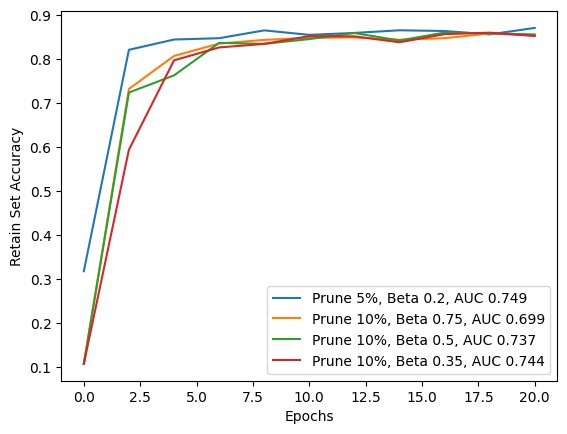

In [36]:
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

plt.plot(epochs, all_retain_accs[0], label="Prune 5%, Beta 0.2, AUC 0.749")
plt.plot(epochs, all_retain_accs[1], label="Prune 10%, Beta 0.75, AUC 0.699")
plt.plot(epochs, all_retain_accs[2], label="Prune 10%, Beta 0.5, AUC 0.737")
plt.plot(epochs, all_retain_accs[3], label="Prune 10%, Beta 0.35, AUC 0.744")

#plt.title("Change in Retain Set Accuracy Through Pruned Model Using Student-Teacher Training")
plt.xlabel("Epochs")
plt.ylabel("Retain Set Accuracy")
plt.legend()

plt.show()
#plt.savefig("pruned_finetuning_retain_acc.png")

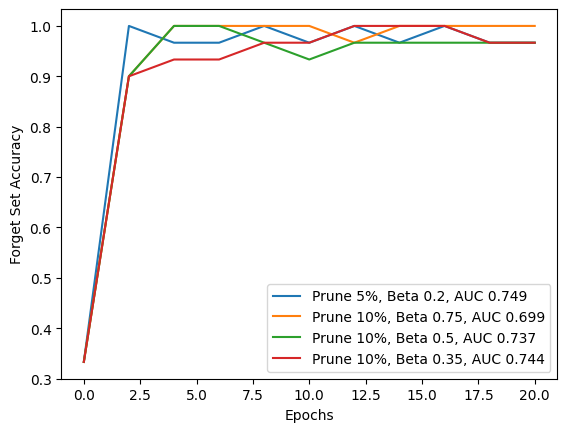

In [31]:
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

plt.plot(epochs, all_forget_accs[0], label="Prune 5%, Beta 0.2, AUC 0.749")
plt.plot(epochs, all_forget_accs[1], label="Prune 10%, Beta 0.75, AUC 0.699")
plt.plot(epochs, all_forget_accs[2], label="Prune 10%, Beta 0.5, AUC 0.737")
plt.plot(epochs, all_forget_accs[3], label="Prune 10%, Beta 0.35, AUC 0.744")

#plt.title("Change in Forget Set Accuracy Through Pruned Model Using Student-Teacher Training")
plt.xlabel("Epochs")
plt.ylabel("Forget Set Accuracy")
plt.legend()

plt.show()
#plt.savefig("pruned_finetuning_retain_acc.png")